In [1]:
from matchms.importing import load_from_mgf
import os
from collections import defaultdict
import networkx as nx
import numpy as np
from collections import deque
from collections import Counter
import pandas as pd
import json
import matchms
from matchms import Spectrum
from matchms.importing import load_from_mgf
from matchms.exporting import save_as_mgf
from typing import List, Union
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from massspecgym.data.transforms import MolFingerprinter
from massspecgym.data.datasets import MSnDataset

from massspecgym.tools.plots import visualize_tree
from massspecgym.tools.analyzers import analyze_trees
from rdkit import Chem
from massspecgym.utils import (
    morgan_fp, init_plotting, smiles_to_scaffold,
    train_val_test_split, create_split_file,
    MyopicMCES
    )

In [2]:
fingerprinter = MolFingerprinter()
msn_dataset = MSnDataset(pth="/Users/macbook/CODE/MS/data/MSn/MSn/20240914_msn_library_pos_all_lib_MSn.mgf", mol_transform=MolFingerprinter.from_smiles)
print(len(msn_dataset))

16476


In [ ]:
fingerprinter = MolFingerprinter()

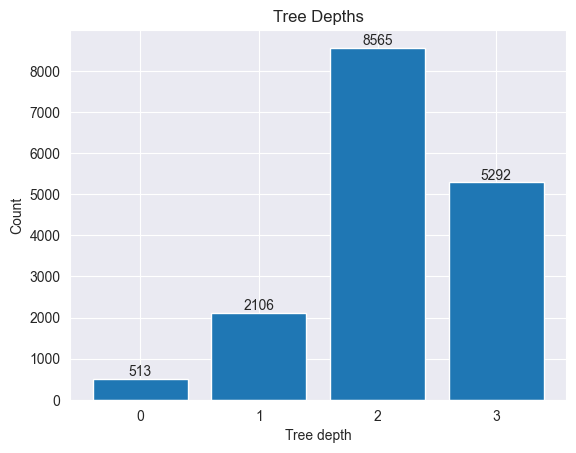

In [5]:
branching = msn_dataset.tree_depths
bins = [0, 1, 2, 3, 4]  # Extend the bins to include the upper edge

counts, _ = np.histogram(branching, bins=bins)

plt.bar(bins[:-1], counts, width=0.8, align='center')
plt.title("Tree Depths")
plt.xlabel("Tree depth")
plt.ylabel("Count")
plt.xticks(bins[:-1])

# Add the number of occurrences above the bars
for i, count in enumerate(counts):
    plt.text(bins[i], count, str(count), ha='center', va='bottom')

plt.show()

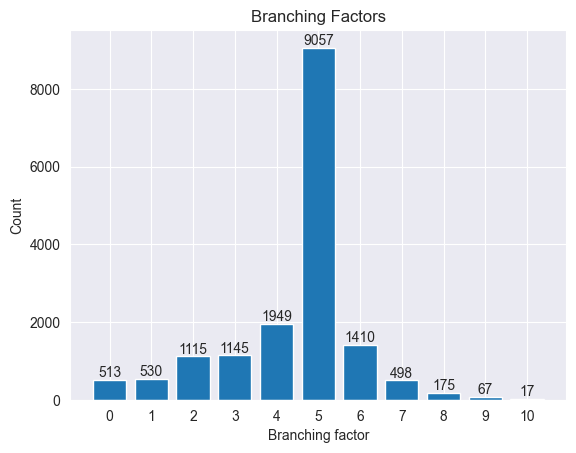

In [6]:
branching = msn_dataset.branching_factors
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

counts, _ = np.histogram(branching, bins=bins)

plt.bar(bins[:-1], counts, width=0.8, align='center')
plt.title("Branching Factors")
plt.xlabel("Branching factor")
plt.ylabel("Count")
plt.xticks(bins[:-1])

# Add the number of occurrences above the bars
for i, count in enumerate(counts):
    plt.text(bins[i], count, str(count), ha='center', va='bottom')

plt.show()

In [9]:
msn_dataset.spectra[0].mz

array([ 41.038666,  42.033859,  43.017909,  45.033539,  48.270996,
        50.015167,  51.022966,  52.03078 ,  53.0386  ,  54.046406,
        55.017859,  55.054256,  63.022903,  64.030739,  65.038557,
        66.046393,  67.017783,  67.054189,  68.025661,  68.997043,
        69.033432,  71.049108,  76.030754,  77.038532,  77.04055 ,
        78.046351,  78.048393,  79.017815,  79.054169,  79.056244,
        80.025613,  80.061997,  81.033445,  82.041262,  83.049086,
        89.038534,  89.041008,  89.059807,  90.046379,  91.054189,
        92.062042,  93.033461,  93.069883,  94.041317,  95.049123,
        97.028393,  98.036249,  99.044049, 102.046368, 103.054229,
       104.062031, 105.033461, 105.044684, 105.069876, 106.041313,
       107.044777, 107.049115, 107.052964, 107.055863, 108.020583,
       108.056942, 108.065681, 109.028376, 109.064786, 110.036257,
       111.044055, 112.051903, 113.059799, 115.054205, 118.04135 ,
       119.049287, 119.060423, 120.057009, 121.028455, 121.039

In [13]:
msn_dataset.spectra[0].intensities

array([1.8200e-01, 7.8000e-02, 2.2000e-01, 1.3300e-01, 7.6000e-02,
       2.2000e-01, 5.1950e+00, 4.9700e-01, 1.0990e+00, 1.5000e-01,
       1.1970e+00, 1.0800e-01, 3.5700e-01, 1.6600e-01, 1.7720e+00,
       3.3600e-01, 3.0700e-01, 4.7400e-01, 1.2400e-01, 4.1700e-01,
       1.3110e+00, 7.4000e-02, 8.3000e-02, 5.9740e+00, 1.0900e-01,
       6.6020e+00, 1.2600e-01, 2.5500e-01, 9.3010e+00, 1.9100e-01,
       4.5800e-01, 3.6800e+00, 2.0300e-01, 6.5500e-01, 6.5900e-01,
       5.4770e+00, 9.1000e-02, 6.2000e-02, 5.6220e+00, 5.9410e+00,
       1.2500e-01, 5.0800e-01, 2.3500e-01, 2.1000e-01, 4.8130e+00,
       3.0750e+00, 1.2200e-01, 3.1830e+00, 2.5500e-01, 8.9700e-01,
       6.0400e-01, 1.2440e+01, 1.9410e+00, 3.7900e-01, 4.7850e+00,
       1.3300e-01, 3.7191e+01, 4.3100e-01, 1.1700e-01, 1.0690e+00,
       7.3540e+00, 1.0900e-01, 1.8900e-01, 2.1300e-01, 1.6100e-01,
       1.1150e+00, 4.0930e+00, 8.8000e-02, 1.3300e-01, 1.8140e+00,
       4.0400e-01, 1.6000e-01, 2.1700e-01, 1.7600e-01, 1.6600e

In [14]:
print(msn_dataset.spectra[0].peaks.to_numpy)

[[4.10386660e+01 1.82000000e-01]
 [4.20338590e+01 7.80000000e-02]
 [4.30179090e+01 2.20000000e-01]
 [4.50335390e+01 1.33000000e-01]
 [4.82709960e+01 7.60000000e-02]
 [5.00151670e+01 2.20000000e-01]
 [5.10229660e+01 5.19500000e+00]
 [5.20307800e+01 4.97000000e-01]
 [5.30386000e+01 1.09900000e+00]
 [5.40464060e+01 1.50000000e-01]
 [5.50178590e+01 1.19700000e+00]
 [5.50542560e+01 1.08000000e-01]
 [6.30229030e+01 3.57000000e-01]
 [6.40307390e+01 1.66000000e-01]
 [6.50385570e+01 1.77200000e+00]
 [6.60463930e+01 3.36000000e-01]
 [6.70177830e+01 3.07000000e-01]
 [6.70541890e+01 4.74000000e-01]
 [6.80256610e+01 1.24000000e-01]
 [6.89970430e+01 4.17000000e-01]
 [6.90334320e+01 1.31100000e+00]
 [7.10491080e+01 7.40000000e-02]
 [7.60307540e+01 8.30000000e-02]
 [7.70385320e+01 5.97400000e+00]
 [7.70405500e+01 1.09000000e-01]
 [7.80463510e+01 6.60200000e+00]
 [7.80483930e+01 1.26000000e-01]
 [7.90178150e+01 2.55000000e-01]
 [7.90541690e+01 9.30100000e+00]
 [7.90562440e+01 1.91000000e-01]
 [8.002561

In [ ]:
msn_dataset.spectra[0].peaks.to_numpy

# New trees

In [2]:
mol_transform = MolFingerprinter()
msn_dataset = MSnDataset(pth="/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20240929_msn_library_pos_all_lib_MSn.mgf", mol_transform=mol_transform,
                         max_allowed_deviation=0.005)
print(len(msn_dataset))

16476


In [3]:
deviations = msn_dataset.get_all_deviations()

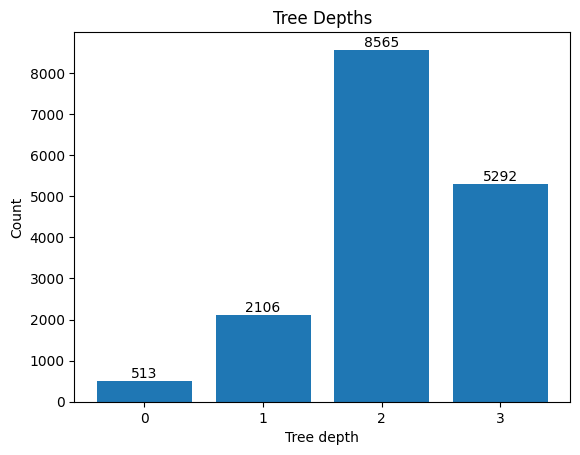

In [4]:
branching = msn_dataset.tree_depths
bins = [0, 1, 2, 3, 4]  # Extend the bins to include the upper edge

counts, _ = np.histogram(branching, bins=bins)

plt.bar(bins[:-1], counts, width=0.8, align='center')
plt.title("Tree Depths")
plt.xlabel("Tree depth")
plt.ylabel("Count")
plt.xticks(bins[:-1])

# Add the number of occurrences above the bars
for i, count in enumerate(counts):
    plt.text(bins[i], count, str(count), ha='center', va='bottom')

plt.show()

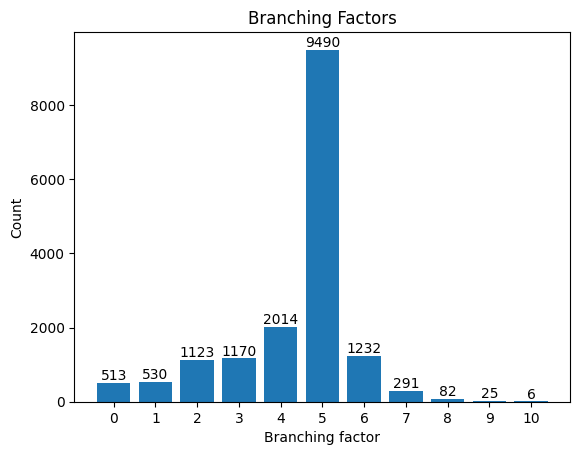

In [5]:
branching = msn_dataset.branching_factors
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

counts, _ = np.histogram(branching, bins=bins)

plt.bar(bins[:-1], counts, width=0.8, align='center')
plt.title("Branching Factors")
plt.xlabel("Branching factor")
plt.ylabel("Count")
plt.xticks(bins[:-1])

# Add the number of occurrences above the bars
for i, count in enumerate(counts):
    plt.text(bins[i], count, str(count), ha='center', va='bottom')

plt.show()

# Take 5 trees

In [6]:
def extract_five_trees(input_mgf: str, output_mgf: str, num_trees: int = 5):
    """
    Extracts the first `num_trees` spectral trees from an MGF file and saves them to a new MGF file.

    Parameters:
    - input_mgf (str): Path to the input MGF file.
    - output_mgf (str): Path to the output MGF file where the selected trees will be saved.
    - num_trees (int): Number of trees to extract (default is 5).
    """
    trees: List[List[Spectrum]] = []   
    current_tree: List[Spectrum] = []   

    for spectrum in load_from_mgf(input_mgf):
        metadata = spectrum.metadata

        spectype = metadata.get('spectype', '')
        if spectype != 'ALL_ENERGIES':
            continue

        # Retrieve MS_LEVEL; default to '1' if not present
        ms_level = str(metadata.get('ms_level', '1'))

        if ms_level == '2':
            # If there's an existing tree, add it to the list of trees
            if current_tree:
                trees.append(current_tree)
                if len(trees) == num_trees:
                    break
                current_tree = []

            # Start a new tree with the root spectrum
            current_tree.append(spectrum)
        else:
            # If within a tree, add the child spectrum to the current tree
            if current_tree:
                current_tree.append(spectrum)

    if len(trees) < num_trees and current_tree:
        trees.append(current_tree)

    selected_spectra: List[Spectrum] = []
    for tree in trees[:num_trees]:
        selected_spectra.extend(tree)
    save_as_mgf(selected_spectra, output_mgf, export_style='matchms')

    print(f"Saved {len(trees[:num_trees])} trees with a total of {len(selected_spectra)} spectra to '{output_mgf}'.")

In [7]:
# extract_five_trees('../../../data/MSn/20240917_msn_library_pos_all_lib_MSn.mgf', '../../../data/MSn/five_trees.mgf', 5)

# Analyze created trees

In [8]:
path_to_spectra =  "../../../data/MSn/20240929_msn_library_pos_all_lib_MSn.mgf"
result = analyze_trees(msn_dataset.trees, path_to_spectra, spectype = 'ALL_ENERGIES', deviations=deviations)

Maximum deviation found: 0.003662109375
--- Molecule-Level Statistics ---
Total number of unique molecules: 13984
Number of unique molecules with at least one tree missing spectra nodes: 10
Number of unique molecules where all trees have missing spectra nodes: 6
Number of unique molecules with at least one complete tree: 13978

Top 10 molecules with the most trees missing spectra:
1. SMILES: CC(=O)OC[C@@]12C(=O)C[C@@H](C)[C@]3(C[C@@H](c4cocc4)OC3=O)[C@H]1CC[C@H](OC(C)=O)[C@]21CO1, Missing Trees: 1 out of 3 trees
2. SMILES: CCCOc1nc(C)nc(N2CCN(C(=O)c3c(OC)ccc(Cl)c3)CC2)c1, Missing Trees: 1 out of 1 trees
3. SMILES: Nc1c2nc(SCCO)nc-2n(Cc2ccccc2)cn1, Missing Trees: 1 out of 1 trees
4. SMILES: Cc1cc(-c2ccncc2)nn1CCNC(=O)CN(C)S(C)(=O)=O, Missing Trees: 1 out of 1 trees
5. SMILES: CCOC(=O)C(C)n1cnc2c(nnn2Cc2ccccc2)c1=O, Missing Trees: 1 out of 1 trees
6. SMILES: COC(=O)CCNC(=O)C(CC(C)C)NC(=O)c1ccc(Cl)cc1, Missing Trees: 1 out of 1 trees
7. SMILES: O=C(Nc1cnccc1)c1cc(C(=O)c2c(F)cccc2Br)c[nH]1

In [7]:
visualize_tree(
    tree=result['tree_level']['top_n_trees_missing_spectra'][0][0],
    save_path='/Users/macbook/CODE/Majer:MassSpecGym/data/debug/tree_visualization.png',  
    figsize=(20, 20),
)

Tree visualization saved to /Users/macbook/CODE/Majer:MassSpecGym/data/debug/tree_visualization.png


In [15]:
len(result['tree_level']['top_n_trees_missing_spectra'])

10

In [17]:
for i, missing_node_tree in enumerate(result['tree_level']['top_n_trees_missing_spectra']):
    visualize_tree(
    tree=missing_node_tree[0],
    save_path=f'/Users/macbook/CODE/Majer:MassSpecGym/data/debug/tree_visualization{i}.png', 
    figsize=(20, 20),
)

Tree visualization saved to /Users/macbook/CODE/Majer:MassSpecGym/data/debug/tree_visualization0.png
Tree visualization saved to /Users/macbook/CODE/Majer:MassSpecGym/data/debug/tree_visualization1.png
Tree visualization saved to /Users/macbook/CODE/Majer:MassSpecGym/data/debug/tree_visualization2.png
Tree visualization saved to /Users/macbook/CODE/Majer:MassSpecGym/data/debug/tree_visualization3.png
Tree visualization saved to /Users/macbook/CODE/Majer:MassSpecGym/data/debug/tree_visualization4.png
Tree visualization saved to /Users/macbook/CODE/Majer:MassSpecGym/data/debug/tree_visualization5.png
Tree visualization saved to /Users/macbook/CODE/Majer:MassSpecGym/data/debug/tree_visualization6.png
Tree visualization saved to /Users/macbook/CODE/Majer:MassSpecGym/data/debug/tree_visualization7.png
Tree visualization saved to /Users/macbook/CODE/Majer:MassSpecGym/data/debug/tree_visualization8.png
Tree visualization saved to /Users/macbook/CODE/Majer:MassSpecGym/data/debug/tree_visualiza